In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def initialize_parameters(layers_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)
    
    return parameters

In [3]:
# activation functions
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def leaky_relu(x):
    return np.maximum(0.1 * x, x)

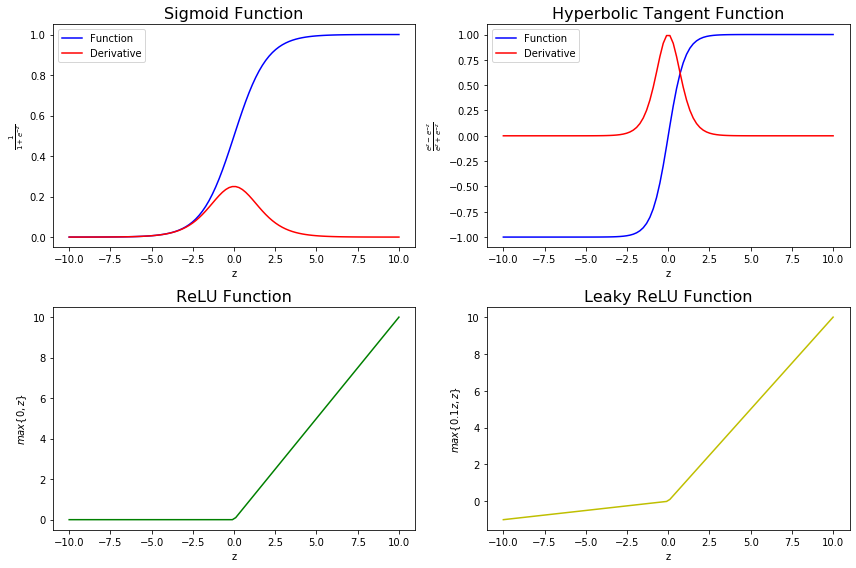

In [4]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid = sigmoid(z)
A_tanh = tanh(z)
A_relu = relu(z)
A_leaky_relu = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, 'b', label="Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), 'r', label = "Derivative") 
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize=16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r', label="Derivative") 
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$") 
plt.title("Hyperbolic Tangent Function", fontsize=16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize=16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize=16)
plt.tight_layout();

In [5]:
# gradient descent of activation functions
def relu_gradient(x):
    return np.int64(x > 0)

def sigmoid_gradient(x):
    q = sigmoid(x)
    return q * (1-q)

def tanh_gradient(x):
    q = tanh(x)
    return (1 - np.square(q))

def leaky_relu_gradient(x):
    return (1 if x > 0 else 0.1)

In [6]:
# softmax
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))
def stable_softmax(x):
    exps = np.exp(x - x.max())
    return exps/np.sum(exps)

In [7]:
# forward propagation
def linear_forward(x, W, b):
    return (np.dot(W, x) + b)

def linear_activation_forward(x, W, b, activation_fn):
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or activation_fn == "relu" or activation_fn == "leaky_relu" or activation_fn == "softmax" or activation_fn == "stable_softmax"
    
    if activation_fn == "sigmoid":
        h_in = linear_forward(x, W, b)
        h_out = sigmoid(h_in)
        
    elif activation_fn == "tanh":
        h_in = linear_forward(x, W, b)
        h_out = tanh(h_in)

    elif activation_fn == "relu":
        h_in = linear_forward(x, W, b)
        h_out = relu(h_in)
        
    elif activation_fn == "leaky_relu":
        h_in = linear_forward(x, W, b)
        h_out = leaky_relu(h_in)
        
    elif activation_fn == "softmax":
        h_in = linear_forward(x, W, b)
        h_out = softmax(h_in)
        
    elif activation_fn == "stable_softmax":
        h_in = linear_forward(x, W, b)
        h_out = stable_softmax(h_in)
    
    return h_in, h_out

def model_forward(x, parameters, hidden_layers_activation_fn="relu", output_layer_activation_fn="softmax"):
    L = len(parameters) // 2
    h_in = []
    h_out = []
    for l in range(1, L):
        Z, x = linear_activation_forward(
            x, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        h_in.append(Z)
        h_out.append(x)
        
    # last layer
    Z, x  = linear_activation_forward(
        x, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn=output_layer_activation_fn)
    h_in.append(Z)
    h_out.append(x)
    
    return h_in, h_out

def model_forward_mse(x, parameters, hidden_layers_activation_fn="relu"):
    L = len(parameters) // 2
    h_in = []
    h_out = []
    for l in range(1, L):
        Z, x = linear_activation_forward(
            x, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        h_in.append(Z)
        h_out.append(x)
        
    # last layer
    Z, x  = linear_activation_forward(
        x, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="stable_softmax")
    h_in.append(Z)
    h_out.append(x)
    
    return h_in, h_out

In [8]:
# loading data
import os
import urllib
from urllib.request import urlretrieve
dataset = 'mnist.pkl.gz'
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
    
if not os.path.isfile(dataset):
        origin = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"
        print('Downloading data from %s' % origin)
        urlretrieve(origin, dataset, reporthook=reporthook)

In [9]:
import gzip
import pickle
with gzip.open(dataset, 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [10]:
# 設定好訓練及測試資料
X_train, y_train = train_set
X_test, y_test = test_set
# 設定成我們的格式
X_train = X_train[..., None]
X_test = X_test[..., None]

In [11]:
print(f"""dimensions:\n{40 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

dimensions:
----------------------------------------
Training: (50000, 784, 1), (50000,)
Test: (10000, 784, 1), (10000,)


### Gradient Descent

#### Activation Function

* softmax
![softmax](https://miro.medium.com/max/549/1*V5wVwcT3BIZMvvVBAspT1A.gif)

* sigmoid
![sigmoid](https://miro.medium.com/max/666/1*JQZDpbYJz1a-T59FMUEFLQ.gif)

#### Loss Function

* cross entropy with sigmoid function
![CE_Sigmoid](https://miro.medium.com/max/490/1*G5kcWWa1Exi-Z7mbw2sO4w.gif)

* mean square error with sigmoid function
![MSE_Sigmoid](https://miro.medium.com/max/528/1*-D-Se-KFq6kJEGG6iPRcyg.gif)

* cross entropy with sofmax function
![CE_Softmax](https://miro.medium.com/max/573/1*ZSqKFow-2W3fWYpmAKp6bw.gif)

* mean square error  with sofmax function
![MSE_Softmax](https://miro.medium.com/max/559/1*FqdJftA2bB5vf1uzCQ8yGQ.gif)


In [43]:
def mse_gradient(q, p, y):
    loss = np.copy(p)
    indx = 0
    for i, j in zip(q, p):
        s = i[0]
        t = j[0]
        if t == 1:
            loss[indx][0] = (i[0]**2-i[0]*(1+np.sum(q[:y+1]**2)))*4/10
#             loss[indx][0] = (2*(s-t)*(2*s - (s/(1-s))*(1-np.sum(s**2))))
        else:
            loss[indx][0] = (i[0]**2-i[0]*(-1*(q[y][0])+np.sum(q[:y+1]**2)))*2/10
#             loss[indx][0] = (2*(s-t)*(s + q[y][0] - np.sum(s**2)))
        indx += 1
    return loss

In [12]:
# Cross Entropy + Softmax
from time import time

# Setting layers dims
layers_dims = [X_train.shape[1], 50, 10]
# initialize parameters
parameters = initialize_parameters(layers_dims)
γ = 0.03
EPOCH = 10
n_data = X_train.shape[0]
t0 = time()

print('epoch \t score \t\t time \t loss')
for epochs in range(EPOCH):
    idx = np.random.choice(n_data, n_data, replace=False)
    for i in idx:
        x = X_train[i]
        y = y_train[i]
        # forward propagation
        h_in, h_out = model_forward(x, parameters, hidden_layers_activation_fn="relu", output_layer_activation_fn="softmax")
        q = h_out[-1]
        p = np.eye(10)[y][:, None]
        L = - np.log(q[y])[0]
        # backward propagation
        grad_b2 = q - p
        grad_w2 = grad_b2 @ h_out[0].T
        grad_b1 = (parameters['W2'].T @ grad_b2) * relu_gradient(h_in[0])
        grad_w1 = grad_b1 @ x.T
        # update parameters
        parameters['W1'] -= γ * grad_w1
        parameters['W2'] -= γ * grad_w2
        parameters['b1'] -= γ * grad_b1
        parameters['b2'] -= γ * grad_b2
    score = ((parameters['W2']@relu(parameters['W1']@X_test+parameters['b1'])+parameters['b2']).argmax(axis=1).ravel()==y_test).mean()
    print(epochs, "\t", "%.4f"%score, "\t", "%.1f"%(time()-t0), "\t", L)
print(time()-t0)

epoch 	 score 		 time 	 loss
0 	 0.9461 	 23.9 	 0.0028431657824201134
1 	 0.9500 	 48.2 	 0.09645907638894068
2 	 0.9498 	 71.4 	 5.0446778211458285e-05
3 	 0.9430 	 95.0 	 1.5283778036642546e-06
4 	 0.9596 	 118.7 	 0.1591030236866991
5 	 0.9580 	 141.2 	 3.827144550876125e-07
6 	 0.9504 	 162.2 	 5.440092820663282e-15
7 	 0.9597 	 184.7 	 8.881784197001256e-16
8 	 0.9627 	 207.0 	 0.10436878353651152
9 	 0.9531 	 229.5 	 1.243449787580183e-14
229.49479722976685


In [13]:
# Mean Square Error + Sigmoid
from time import time

# Setting layers dims
layers_dims = [X_train.shape[1], 50, 10]
# initialize parameters
parameters = initialize_parameters(layers_dims)
γ = 0.03
EPOCH = 10
n_data = X_train.shape[0]
t0 = time()

print('epoch \t score \t\t time \t loss')
for epochs in range(EPOCH):
    idx = np.random.choice(n_data, n_data, replace=False)
    for i in idx:
        x = X_train[i]
        y = y_train[i]
        # forward propagation
        h_in, h_out = model_forward(x, parameters, hidden_layers_activation_fn="relu", output_layer_activation_fn="sigmoid")
        q = h_out[-1]
        p = np.eye(10)[y][:, None]
        L = np.sum((q-p)**2)/10
        # backward propagation
        grad_b2 = 2*q*(1-q)*(q-p)
        grad_w2 = grad_b2 @ h_out[0].T
        grad_b1 = (parameters['W2'].T @ grad_b2) * relu_gradient(h_in[0])
        grad_w1 = grad_b1 @ x.T
        # update parameters
        parameters['W1'] -= γ * grad_w1
        parameters['W2'] -= γ * grad_w2
        parameters['b1'] -= γ * grad_b1
        parameters['b2'] -= γ * grad_b2
    score = ((parameters['W2']@relu(parameters['W1']@X_test+parameters['b1'])+parameters['b2']).argmax(axis=1).ravel()==y_test).mean()
    print(epochs, "\t", "%.4f"%score, "\t", "%.1f"%(time()-t0), "\t", L)
print(time()-t0)

epoch 	 score 		 time 	 loss
0 	 0.9485 	 21.8 	 0.006842104210842417
1 	 0.9601 	 43.8 	 0.06642743390083569
2 	 0.9636 	 67.3 	 5.804191107580818e-07
3 	 0.9626 	 90.4 	 1.76230754363765e-08
4 	 0.9675 	 112.4 	 0.00034318484172886745
5 	 0.9680 	 134.9 	 2.0984479727464288e-06
6 	 0.9651 	 157.6 	 1.1791405586685629e-15
7 	 0.9691 	 180.0 	 1.009645012178963e-06
8 	 0.9718 	 203.2 	 8.555429536577077e-09
9 	 0.9721 	 224.1 	 4.775028882320831e-15
224.07602500915527
